In [1]:
from src.utils.utils import get_algo_by_name, get_env_by_name
from src.utils.save_results import get_task_name, get_metrics_information, get_results_file_name
import numpy as np
import time
import os
from datetime import date
from tqdm import tqdm
from tqdm.notebook import trange, tqdm
today = date.today()
import matplotlib.pyplot as plt
# import seaborn as sns; sns.set()

def do_single_experiment(rd, settings):
    env = get_env_by_name(settings)
    env.set()
    agent = get_algo_by_name(settings)
    agent.set_environment(env)
    metrics = agent.iterate_learning()
    return metrics

In [2]:
nb_rds = 20
max_rounds = 1000
nb_levels = 2

def do_paradox_experiment(nb_childs):

    exp3_regrets = np.zeros((nb_rds, int(max_rounds/100)))
    exp3_rewards = np.zeros((nb_rds, int(max_rounds/100)))
    new_regrets = np.zeros((nb_rds, int(max_rounds/100)))
    new_rewards = np.zeros((nb_rds, int(max_rounds/100)))
    nexp3_regrets = np.zeros((nb_rds, int(max_rounds/100)))
    nexp3_rewards = np.zeros((nb_rds, int(max_rounds/100)))

    for rd in range(nb_rds):
        settings = {
            'rd': rd,
            'max_rounds': max_rounds,
            'nb_leaves_per_class': nb_childs,
            'nb_levels': nb_levels,
            'env': 'paradox',
            'algo': 'exp3',
        }
        metrics = do_single_experiment(rd, settings)
        rounds = metrics['round']
        exp3_regrets[rd] = metrics['regret']
        exp3_rewards[rd] = metrics['reward']

        settings['algo'] = 'new'
        metrics = do_single_experiment(rd, settings)
        rounds = metrics['round']
        new_regrets[rd] = metrics['regret']
        new_rewards[rd] = metrics['reward']
        
        settings['algo'] = 'nexp3'
        metrics = do_single_experiment(rd, settings)
        rounds = metrics['round']
        nexp3_regrets[rd] = metrics['regret']
        nexp3_rewards[rd] = metrics['reward']

    # EXP3
    exp3_rgrt_std = np.std(exp3_regrets, axis=0)
    exp3_rwd_std = np.std(exp3_rewards, axis=0)
    exp3_regret = np.mean(exp3_regrets, axis=0)
    exp3_reward = np.mean(exp3_rewards, axis=0)
    
    exp3_result = (exp3_regret, exp3_rgrt_std, exp3_reward, exp3_rwd_std)

    # NEW
    new_rgrt_std = np.std(new_regrets, axis=0)
    new_rwd_std = np.std(new_rewards, axis=0)
    new_regret = np.mean(new_regrets, axis=0) 
    new_reward = np.mean(new_rewards, axis=0)
    
    new_result = (new_regret, new_rgrt_std, new_reward, new_rwd_std)

    # NEXP3
    nexp3_rgrt_std = np.std(nexp3_regrets, axis=0)
    nexp3_rwd_std = np.std(nexp3_rewards, axis=0)
    nexp3_regret = np.mean(nexp3_regrets, axis=0) 
    nexp3_reward = np.mean(nexp3_rewards, axis=0)
    
    nexp3_result = (nexp3_regret, nexp3_rgrt_std, nexp3_reward, nexp3_rwd_std)
    
    return exp3_result, new_result, nexp3_result, list(np.array(exp3_regrets)[:,-1]), list(np.array(new_regrets)[:,-1]), list(np.array(nexp3_regrets)[:,-1])

In [3]:
nb_childs = [2, 5, 10, 50]
res_new = []
res_nexp3 = []
res_exp3 = []
res=[]
labels=[]
exp3_results = []
nexp3_results = []
new_results = []

for nb_child in tqdm(nb_childs):
    a,b,c,d,e,f = do_paradox_experiment(nb_child)
    res_exp3.append(list(d))
    res_new.append(e)
    res_nexp3.append(f)
    res.append(d)
    res.append(e)
    res.append(f)
    labels.append('EXP3 - N {}'.format(nb_child))
    labels.append('NEW - N {}'.format(nb_child))
    labels.append('Nexp3 - N {}'.format(nb_child))
    exp3_results.append(a)
    nexp3_results.append(b)
    new_results.append(c)

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 8345.56it/s]


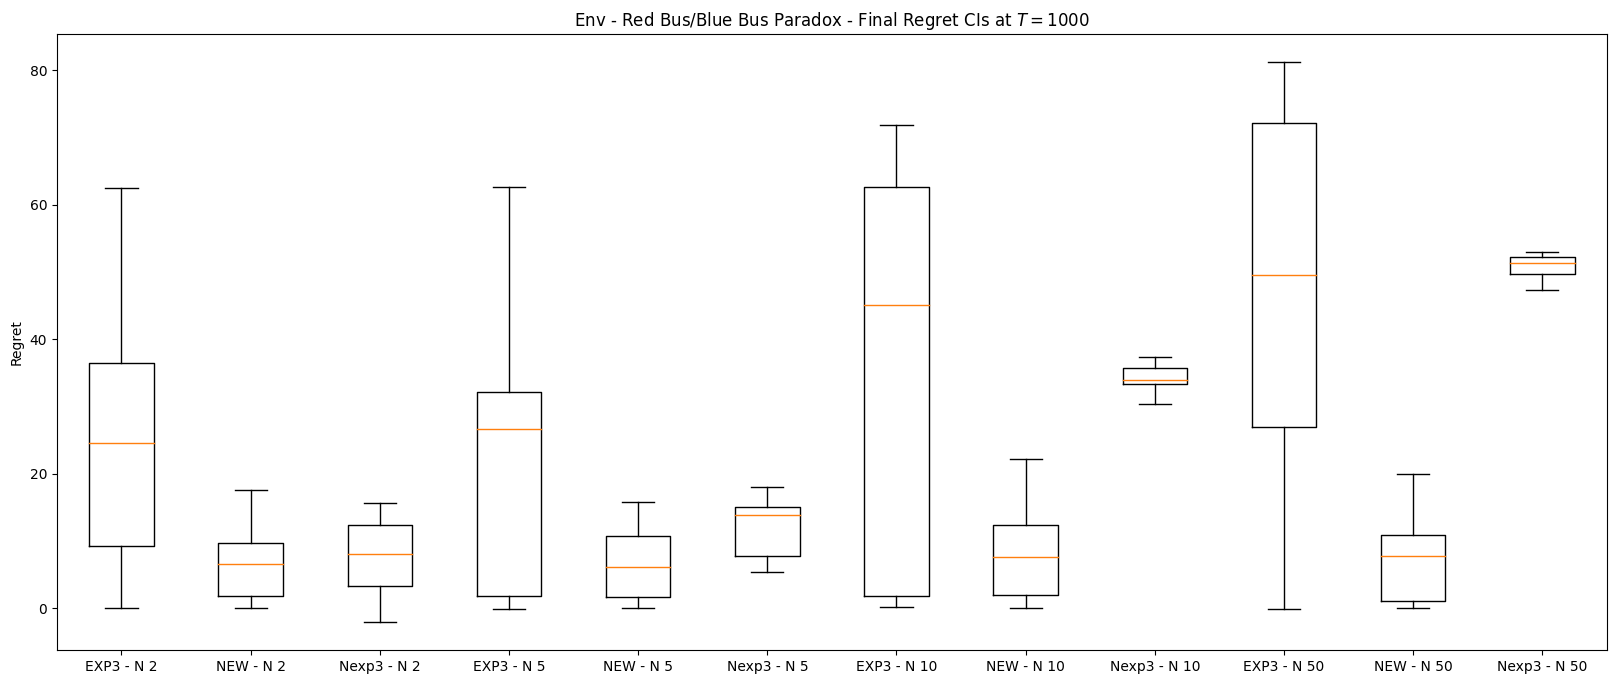

In [4]:
plt.figure(figsize=(20,8))
plt.boxplot(res, labels=labels)
plt.ylabel('Regret')
plt.title('Env - Red Bus/Blue Bus Paradox - Final Regret CIs at $T=1000$')

plt.savefig('figure_bbrb_regret_slice.pdf', bbox_inches = "tight")
plt.show()